In [33]:
import os
import sys
thread = 8 #sys.argv[1]
os.environ["OMP_NUM_THREADS"] = str(thread) # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = str(thread) # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = str(thread) # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = str(thread) # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = str(thread) # export NUMEXPR_NUM_THREADS=6
import matplotlib.pyplot as plt

import gpflow
import numpy as np
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic, WhiteKernel
import GPy
import gpflow
import pyro
import torch
import pyro.contrib.gp as pyrogp
import pyro.distributions as dist
import tensorflow as tf
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.util import torch_backward, torch_item
from pyro.contrib.autoguide import AutoMultivariateNormal
from torch.distributions import constraints
from torch.nn import Parameter
from pyro.optim import Adam

In [28]:
X = np.load("./data/X.npy")
y = np.loadtxt("./data/E_def2-tzvp.dat")

In [2]:
class GPR_benchmark():
    def __init__(self, avg_mae, avg_training_time_cpu, avg_testing_time_cpu, avg_training_time_wall, avg_testing_time_wall):
        self.avg_mae = avg_mae
        self.avg_training_time_cpu = avg_training_time_cpu
        self.avg_testing_time_cpu = avg_testing_time_cpu
        self.avg_training_time_wall = avg_training_time_wall
        self.avg_testing_time_wall = avg_testing_time_wall

In [29]:

class GPR:
    def __init__(self, library='scikit', kernel='gaussian', sigma = 1.0, length_scale=1.0, white_noise=0.1, optimize = False, iterations = 100, jitter = 1e-6):
        self.jitter = jitter
        self.sigma = sigma
        self.library = library
        self.kernel = kernel
        self.length_scale = length_scale
        self.white_noise = white_noise
        self.iterations = iterations
        self.optimize = optimize
        self.is_fit = False
        self.avg_mae = 0
        self.avg_training_time_cpu = 0
        self.avg_testing_time_cpu = 0
        self.avg_training_time_wall = 0
        self.avg_testing_time_wall = 0
    def fit(self, X, y):
        start_cpu = time.process_time()
        start_wall = time.perf_counter()
        self.X = X
        self.y = y
        start_time = time.time()
        if self.library == 'scikit':
            kernel_scikit = None
            if self.kernel == 'gaussian':
                kernel_scikit = self.sigma * RBF(length_scale=self.length_scale) + WhiteKernel(
                    noise_level=self.white_noise, noise_level_bounds=(1e-6, 1e1))
            elif self.kernel == 'laplacian':
                kernel_scikit = self.sigma * RationalQuadratic(length_scale=self.length_scale,
                                                          alpha=1.0) + WhiteKernel(noise_level=self.white_noise,
                                                                                   noise_level_bounds=(1e-6, 1e1))
            if self.optimize:
                self.model = GaussianProcessRegressor(kernel=kernel_scikit,
                                                      alpha = self.jitter,
                                                      n_restarts_optimizer = self.iterations)
            else:
                self.model = GaussianProcessRegressor(kernel=kernel_scikit,
                                                      alpha = self.jitter,
                                                      optimizer = None)
            self.model.fit(X, y)
        elif self.library == 'gpy':
            kernel_gpy = None
            y = np.expand_dims(y, axis=1)
            if self.kernel == 'gaussian':
                kernel_gpy = GPy.kern.RBF(input_dim=X.shape[1],
                                          variance=self.sigma,
                                          lengthscale=self.length_scale, ARD = True)
            elif self.kernel == 'laplacian':
                kernel_gpy = GPy.kern.Exponential(input_dim=X.shape[1],
                                                  variance=self.sigma,
                                                  lengthscale=self.length_scale)

            self.model = GPy.models.GPRegression(X, y, kernel_gpy, noise_var=self.white_noise)
            if self.optimize:
                self.model.optimize(max_iters=self.iterations)
            
        elif self.library == 'gpflow':
            kernel_gpflow = None
            y = np.expand_dims(y, axis=1)
            if self.kernel == 'gaussian':
                kernel_gpflow = gpflow.kernels.SquaredExponential(variance=self.sigma,
                                                                  lengthscales=self.length_scale)
            elif self.kernel == 'laplacian':
                kernel_gpflow = gpflow.kernels.Exponential(variance=self.sigma,
                                                           lengthscales=self.length_scale * 2)
            self.model = gpflow.models.GPR(data=(X, y), kernel=kernel_gpflow,
                                           likelihood = gpflow.likelihoods.Gaussian(variance= self.sigma))
            if self.optimize:
                optimizer = gpflow.optimizers.Scipy()
                optimizer.minimize(self.model.training_loss,
                                   self.model.trainable_variables,
                                   options=dict(maxiter=self.iterations))

        elif self.library == 'pyro':
            self.tensorX = torch.from_numpy(X)
            self.tensory = torch.from_numpy(y)
            kernel_pyro = None
            if self.kernel == 'gaussian':
                kernel_pyro = pyrogp.kernels.RBF(input_dim=X.shape[1],
                                                 variance=torch.tensor(self.sigma),
                                                 lengthscale=torch.tensor(self.length_scale))
            elif self.kernel == 'laplacian':
                kernel_pyro = pyrogp.kernels.Exponential(input_dim=X.shape[1],
                                                         variance=torch.tensor(self.sigma),
                                                         lengthscale=torch.tensor(self.length_scale))
            self.model = pyrogp.models.GPRegression(self.tensorX,
                                                    self.tensory,
                                                    kernel_pyro,
                                                    noise=self.tensorX.new_tensor(self.white_noise),
                                                    jitter=self.jitter)
            if self.optimize:
                print("Optimizer On")
                pyrogp.util.train(self.model, optimizer=None,
                                  loss_fn=None, retain_graph=None,
                                  num_steps=self.iterations)
                
#                 optimizer = torch.optim.Adam(self.model.parameters(), lr=0.05)
#                 autoGuide = AutoMultivariateNormal(self.model)
#                 loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss
#                 losses = []
#                 locations = []
#                 variances = []
#                 lengthscales = []
#                 noises = []
#                 iterations = self.iterations
#                 mae = []


#                 for i in range(iterations):
#                     optimizer.zero_grad()
#                     variances.append(self.model.kernel.variance.item())
#                     noises.append(self.model.noise.item())
#                     lengthscales.append(self.model.kernel.lengthscale.item())
#                     loss = loss_fn(self.model.model, self.model.guide)
#                     torch_backward(loss, True)
#                     optimizer.step()
#                     losses.append(loss.item())
            
                
#         elif self.library == 'pymc3':
#             kernel_pymc3 = None
#             if self.kernel == 'gaussian':
#                 kernel_pymc3 = pm.gp.cov.ExpQuad(input_dim=X.shape[1], ls=self.length_scale, active_dims=[0])
#             elif self.kernel == 'laplacian':
#                 kernel_pymc3 = pm.gp.cov.Exponential(input_dim=X.shape[1], ls=self.length_scale * 2, active_dims=[0])
#             self.model = pmGPR(kernel=kernel_pymc3)
#             self.model.fit(X, y, inference_args={"n": 100})
        end_cpu = time.process_time()
        end_wall = time.perf_counter()
        self.training_time_wall = end_wall - start_wall
        self.training_time_cpu = end_cpu - start_cpu
        self.is_fit = True

    def predict(self, X):
        if not self.is_fit:
            print("Fit model first")
        start_time = time.time()
        start_cpu = time.process_time()
        start_wall = time.perf_counter()
        if self.library == 'scikit':
            y_pred = self.model.predict(X, return_std=False)
        elif self.library == 'gpy':
            y_pred, _ = self.model.predict(X)
        elif self.library == 'gpflow':
            y_pred, _ = self.model.predict_f(X)
        elif self.library == 'pyro':
            with torch.no_grad():
                y_pred, _ = self.model.forward(torch.from_numpy(X))
                y_pred = y_pred.detach().numpy()
#         elif self.library == 'pymc3':
#             y_pred = self.model.predict(X)
        end_cpu = time.process_time()
        end_wall = time.perf_counter()

        self.cpu_time = end_cpu - start_cpu
        self.testing_time_wall = end_wall - start_wall
        self.testing_time_cpu = end_cpu - start_cpu
        return y_pred
    
    def compute_mae(self, X, y):
        y_predicted = self.predict(X)
        self.mae = np.mean(np.abs(y_predicted - y))
        return self.mae

In [ ]:
scikit = GPR(library='scikit', kernel='gaussian', sigma = 1, length_scale=720, white_noise=1e-6)

scikit.fit(X[:8000], y[:8000])

np.mean(abs(y[-200:] - scikit.predict(X[-200:])))

In [ ]:
gpy = GPR(library='gpy', kernel='gaussian', sigma = 1, length_scale=720, white_noise=1e-6)

gpy.fit(X[:8192], y[:8192])

np.mean(abs(y[-200:] - gpy.predict(X[-200:])))

In [32]:

gflow = GPR(library='gpflow', kernel='gaussian', sigma = 1, length_scale=0.5, white_noise=1e-9)

gflow.fit(X[:8192], y[:8192])


#np.mean(abs(y[9000:] - gflow.predict(X[9000:])))

In [ ]:
pyro_ins = GPR(library='pyro', kernel='laplacian', sigma = 0.5, length_scale=720, white_noise=1e-6)

pyro_ins.fit(X[:8000], y[:8000])

np.mean(abs(y[-200:] - pyro_ins.predict(X[-200:])))

In [ ]:
gpr_array = np.empty((13, 4, 2), dtype=object) 
for l, kernel in enumerate(["laplacian", "gaussian"]):
    for k, lib in enumerate(["scikit", "gpy", "gpflow", "pyro" ]):
        mae_array = np.zeros((12,))
        training_wall_array = np.zeros((12,))
        testing_wall_array = np.zeros((12,))
        training_cpu_array = np.zeros((12,))
        testing_cpu_array = np.zeros((12,))
        for j in range(1, 11):
            for i in range(12):
                N = pow(2, i+1)
                if N > 10000:
                    break
                X_copy = X.copy()
                y_copy = y.copy()
                np.random.seed(j)
                np.random.shuffle(X_copy)
                np.random.seed(j)
                np.random.shuffle(y_copy)
                X_train = X_copy[:N]
                y_train = y_copy[:N]
                avg_mae = 0
                X_test = X_copy[9001:]
                y_test = y_copy[9001:]
                gpr_ins = GPR(library=lib, kernel=kernel, sigma = 1, length_scale=0.5, white_noise=1e-9)
                gpr_ins.fit(X_train, y_train)
                training_wall_array[i] += gpr_ins.training_time_wall
                training_cpu_array[i] += gpr_ins.training_time_cpu
                
                

                if N <= 1000:
                    X_test_n = X_copy[9001:9001+N]
                    gpr_ins.predict(X_test_n)
                    #Indent below left for storing test time for 1000 samples instead of 0
                    testing_wall_array[i] += gpr_ins.testing_time_wall
                    testing_cpu_array[i] += gpr_ins.testing_time_cpu
                
                gpr_ins.compute_mae(X_test, y_test)
                mae_array[i] += gpr_ins.mae
                gpr_ins = None

                if j == 10:
                    gpr_array[i, k, l] = GPR_benchmark(mae_array[i] /10,
                                                       training_wall_array[i] /10, 
                                                       testing_wall_array[i] /10,
                                                       training_cpu_array[i] /10,
                                                       testing_cpu_array[i] /10)
for l, kernel in enumerate(["laplacian", "gaussian"]):
    for k, lib in enumerate(["scikit", "gpy", "gpflow", "pyro" ]):
        mae_array = np.zeros((13,))
        training_wall_array = np.zeros((1,))
        testing_wall_array = np.zeros((1,))
        training_cpu_array = np.zeros((1,))
        testing_cpu_array = np.zeros((1,))
        for j in range(1, 11):
            for i in range(12, 13):
                N = pow(2, i+1)
                if N > 10000:
                    break
                X_copy = X.copy()
                y_copy = y.copy()
                np.random.seed(j)
                np.random.shuffle(X_copy)
                np.random.seed(j)
                np.random.shuffle(y_copy)
                X_train = X_copy[:N]
                y_train = y_copy[:N]
                avg_mae = 0
                X_test = X_copy[9001:]
                y_test = y_copy[9001:]
                gpr_ins = GPR(library=lib, kernel=kernel, sigma = 1, length_scale=0.5, white_noise=1e-9)
                gpr_ins.fit(X_train, y_train)
                training_wall_array[i] += gpr_ins.training_time_wall
                training_cpu_array[i] += gpr_ins.training_time_cpu
                
                

                if N <= 1000:
                    X_test_n = X_copy[9001:9001+N]
                    gpr_ins.predict(X_test_n)
                    #Indent below left for storing test time for 1000 samples instead of 0
                    testing_wall_array[i] += gpr_ins.testing_time_wall
                    testing_cpu_array[i] += gpr_ins.testing_time_cpu
                
                gpr_ins.compute_mae(X_test, y_test)
                mae_array[i] += gpr_ins.mae
                gpr_ins = None

                if j == 10:
                    gpr_array[i, k, l] = GPR_benchmark(mae_array[i] /10,
                                                       training_wall_array[i] /10, 
                                                       testing_wall_array[i] /10,
                                                       training_cpu_array[i] /10,
                                                       testing_cpu_array[i] /10)

In [ ]:
outfile = "/home/ssunar/Thesis/data/output_data/GPR_thread_" + str(thread) + ".npy"
np.save(outfile, krr_array)

In [12]:
threads = [1]
gpr_array = np.array([np.load("/home/ssunar/Thesis/data/output_data/GPR_thread_" + str(thread) + ".npy", allow_pickle=True) for thread in threads])

In [13]:
def plot_avg_mae(krr_array):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
    kernel_names = ["Laplacian", "Gaussian"]
    library_names = ["scikit-learn", "gpy", "gpflow", "pyro"]
    for k, kernel_name in enumerate(kernel_names):
        for l, library_name in enumerate(library_names):
            if k == 0:
                alpha = 1
            else:
                alpha = 0.7
            avg_mae_array = np.zeros((13,))
            for i in range(13):
                avg_mae_array[i] = krr_array[0, i, l, k].avg_mae
            axs.loglog(np.arange(1, 14), avg_mae_array, label=library_name+"_"+kernel_name, alpha = alpha)
            axs.set_title(f"Learning curve GPR")
            axs.set_xlabel("Sample Size")
            axs.set_ylabel("Average MAE")
            axs.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig("./img/Learning_curve_GPR.png", dpi = 200)

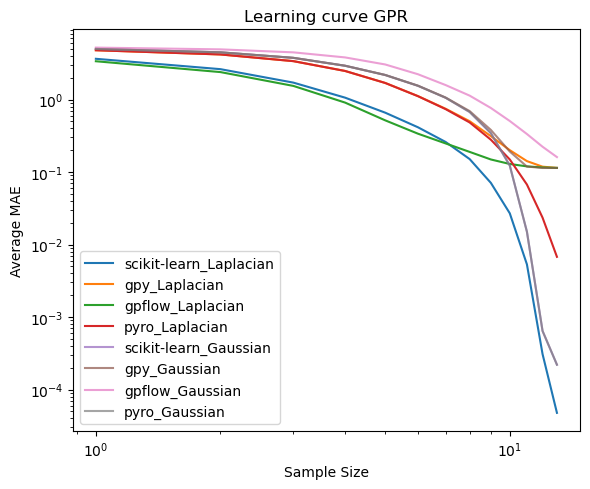

In [14]:
plot_avg_mae(gpr_array)

In [36]:
def plot_avg_training(krr_array):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
    kernel_names = ["Laplacian", "Gaussian"]
    library_names = ["scikit-learn", "gpy", "gpflow", "pyro"]
    times_names = ["cpu_time"]
    threads = [1]
    

    for j, thread in enumerate(threads):
        for t, time_name in enumerate(times_names):
            for l, library_name in enumerate(library_names):
                for k, kernel_name in enumerate(kernel_names):
                    avg_training_time = np.zeros((13,))
                    for i in range(13):
                        if t  == 1:
                            avg_training_time[i] = krr_array[j, i, l, k].avg_training_time_wall
                        else:
                            avg_training_time[i] = krr_array[j, i, l, k].avg_training_time_cpu
                    axs.plot(np.array([2 ** i for i in range(1, 14)]), avg_training_time, label=library_name+"_"+kernel_name, alpha = 0.7)
                    axs.set_title(f"Training time plot KRR, Thread(s) = {thread}")
                    axs.set_xlabel("Sample Size")
                    axs.set_ylabel(f"{time_name} in seconds")
                    axs.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig("./img/Training_time_CPU_GPR.png", dpi = 200)

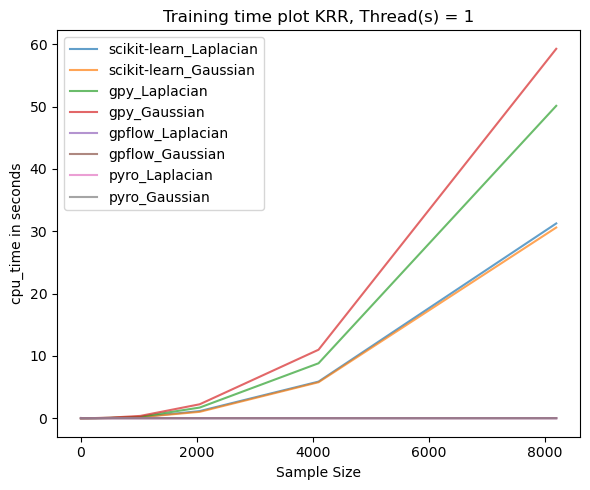

In [37]:
plot_avg_training(gpr_array)

In [38]:
def plot_avg_testing(krr_array):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
    kernel_names = ["Laplacian", "Gaussian"]
    library_names = ["scikit-learn", "gpy", "gpflow", "pyro"]
    times_names = ["cpu_time"]
    threads = [1]
    

    for j, thread in enumerate(threads):
        for t, time_name in enumerate(times_names):
            for l, library_name in enumerate(library_names):
                for k, kernel_name in enumerate(kernel_names):
                    avg_testing_time = np.zeros((9,))
                    for i in range(9):
                        if t  == 1:
                            avg_testing_time[i] = krr_array[j, i, l, k].avg_testing_time_wall
                        else:
                            avg_testing_time[i] = krr_array[j, i, l, k].avg_testing_time_cpu
                    axs.plot(np.array([2 ** i for i in range(1, 10)]), avg_testing_time, label=library_name+"_"+kernel_name, alpha = 0.7)
                    axs.set_title(f"Evaluation time plot KRR, Thread(s) = {thread}")
                    axs.set_xlabel("Sample Size")
                    axs.set_ylabel(f"{time_name} in seconds")
                    axs.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig("./img/Evaluation_time_CPU_GPR.png", dpi = 200)

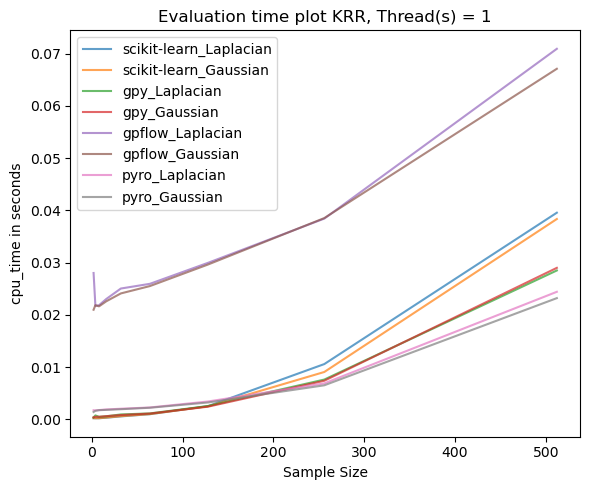

In [39]:
plot_avg_testing(gpr_array)

In [ ]:
def plot_scalability(krr_array):
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12,8))
    kernel_names = ["Laplacian", "Gaussian"]
    library_names = ["scikit-learn", "gpy", "gpflow", "pyro"]
    times_names = ["cpu_time", "wall_time"]
    threads = [i for i in range(1, 21)]
    samples_idx = [9, 11, 12]
    

    for i, sample_idx in enumerate(samples_idx):
        for t, time_name in enumerate(times_names):
            for l, library_name in enumerate(library_names):
                for k, kernel_name in enumerate(kernel_names):
                    avg_training_time= np.zeros((20,))
                    for j, thread in enumerate(threads):
                        if time_name == "wall_time":
                            avg_training_time[j-1] = krr_array[j-1, sample_idx, l, k].avg_training_time_wall
                        else:
                            avg_training_time[j-1] = krr_array[j-1, sample_idx, l, k].avg_training_time_cpu
                    axs[i][t].plot(np.array(threads), avg_training_time, label=library_name+"_"+kernel_name+"_"+time_name, alpha = 0.7)
                    axs[i][t].set_title(f"Training time Scalability plot KRR, Samples={2**(sample_idx+1)}, Time={time_name}")
                    axs[i][t].set_xlabel("Number of threads")
                    axs[i][t].set_ylabel(f"times in seconds")
                    axs[i][t].set_xticks([i for i in range(1, 21, 2)])
                    axs[i][t].legend()
    plt.tight_layout()
    plt.show()
    fig.savefig("./img/Scalability_Training_time_GPR.png", dpi = 200)